<a href="https://colab.research.google.com/github/praveenraghuvanshi1512/EVA4/blob/Session-4/Session-4/Assignment-4/EVA_4_Assignment_4_Praveen_Raghuvanshi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install pytorch and tochvision 
!pip install torch torchvision

In [2]:
!nvidia-smi

Tue Feb 11 21:04:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
# Import libraries
import pandas as pd
import numpy as np

# For reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# For creating validation set
from sklearn.model_selection import train_test_split

# from evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Module, Softmax, Dropout
from torch.optim import Adam, SGD
from torchvision import datasets, transforms, utils

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
# Constants and Hyperparameters
PATH_TO_STORE_TRAINSET = './data'
PATH_TO_STORE_TESTSET = './data'
input_size = 784
output_size = 10

num_epochs = 20
batch_size = 32
learning_rate = 1e-4
random_seed = 1

In [0]:
# Transformations

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                                ])

In [6]:
# Load dataset
train_dataset = datasets.MNIST(root=PATH_TO_STORE_TRAINSET, train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=PATH_TO_STORE_TESTSET,  train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


torch.Size([32, 1, 28, 28])
torch.Size([32])


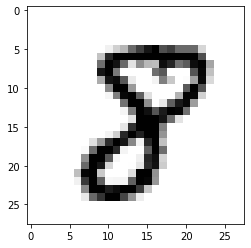

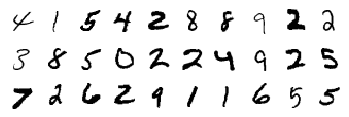

In [9]:
# Data Analysis
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Plot images
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

figure = plt.figure()
num_of_images = 30
for index in range(1, num_of_images + 1):
  plt.subplot(6, 10, index)
  plt.axis('off')
  plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, bias=False)  # Input - 28, Output - 26, RF  - 3
        self.bn1   = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, bias=False) # Input - 26, Output - 24, RF  - 5
        self.bn2   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)               # Input - 24, Output - 12, RF  - 10
        self.conv3 = nn.Conv2d(32, 16, 3, bias=False) # Input - 12, Output - 10, RF  - 12
        self.bn3   = nn.BatchNorm2d(16)
        self.conv4 = nn.Conv2d(16, 32, 3, bias=False) # Input - 10, Output - 8, RF  - 14
        self.bn4   = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)               # Input - 8, Output - 4, RF  - 28
        self.conv5 = nn.Conv2d(32, 10, 4, bias=False) # Input - 4, Output - 2, RF  - 30        
        self.dropout = nn.Dropout2d(0.1)
        
    def forward(self, x):
        x = self.pool1(self.dropout(F.relu(self.bn2(self.conv2(self.dropout(F.relu(self.bn1(self.conv1(x)))))))))
        x = self.pool2(self.dropout(F.relu(self.bn4(self.conv4(self.dropout(F.relu(self.bn3(self.conv3(x)))))))))
        x = self.conv5(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
# initialize CNN, cost, and optimizer
model = Model()
model.to(device)
criterion = nn.NLLLoss()   # with log_softmax() as the last layer, this is equivalent to cross entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# Model summary
from torchsummary import summary
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
         Dropout2d-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,608
       BatchNorm2d-5           [-1, 32, 24, 24]              64
         Dropout2d-6           [-1, 32, 24, 24]               0
         MaxPool2d-7           [-1, 32, 12, 12]               0
            Conv2d-8           [-1, 16, 10, 10]           4,608
       BatchNorm2d-9           [-1, 16, 10, 10]              32
        Dropout2d-10           [-1, 16, 10, 10]               0
           Conv2d-11             [-1, 32, 8, 8]           4,608
      BatchNorm2d-12             [-1, 32, 8, 8]              64
        Dropout2d-13             [-1, 32, 8, 8]               0
        MaxPool2d-14             [-1, 3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [13]:
# Training Time!
import time
import copy

# Some initialization work first...
train_losses, val_losses = [], []
train_accu, val_accu = [], []
start_time = time.time()
early_stop_counter = 10   # stop when the validation loss does not improve for 10 iterations to prevent overfitting
counter = 0
best_val_loss = float('Inf')

for e in tqdm(range(num_epochs)):
    epoch_start_time = time.time()
    running_loss = 0
    accuracy=0
    # training step
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        log_ps = model(images)
        
        ps = torch.exp(log_ps)                
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # record training loss and error, then evaluate using validation data
    train_losses.append(running_loss/len(train_loader))
    train_accu.append(accuracy/len(train_loader))
    val_loss = 0
    accuracy=0
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            log_ps = model(images)
            val_loss += criterion(log_ps, labels)

            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor))
    val_losses.append(val_loss/len(test_loader))
    val_accu.append(accuracy/len(test_loader))

    print("Epoch: {}/{}.. ".format(e+1, num_epochs),
          "Time: {:.2f}s..".format(time.time()-epoch_start_time),
          "Training Loss: {:.3f}.. ".format(train_losses[-1]),
          "Training Accu: {:.3f}.. ".format(train_accu[-1]),
          "Val Loss: {:.3f}.. ".format(val_losses[-1]),
          "Val Accu: {:.3f}".format(val_accu[-1]))

#     print('Epoch %d / %d took %6.2f seconds' % (e+1, epochs, time.time()-epoch_start_time))
#     print('Total training time till this epoch was %8.2f seconds' % (time.time()-start_time))
    
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        counter=0
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter+=1
        print('Validation loss has not improved since: {:.3f}..'.format(best_val_loss), 'Count: ', str(counter))
        if counter >= early_stop_counter:
            print('Early Stopping Now!!!!')
            model.load_state_dict(best_model_wts)
            break

  5%|▌         | 1/20 [00:17<05:38, 17.84s/it]

Epoch: 1/20..  Time: 17.84s.. Training Loss: 0.538..  Training Accu: 0.869..  Val Loss: 0.129..  Val Accu: 0.967


 10%|█         | 2/20 [00:34<05:14, 17.47s/it]

Epoch: 2/20..  Time: 16.59s.. Training Loss: 0.139..  Training Accu: 0.964..  Val Loss: 0.074..  Val Accu: 0.979


 15%|█▌        | 3/20 [00:51<04:53, 17.28s/it]

Epoch: 3/20..  Time: 16.84s.. Training Loss: 0.096..  Training Accu: 0.973..  Val Loss: 0.057..  Val Accu: 0.984


 20%|██        | 4/20 [01:08<04:34, 17.15s/it]

Epoch: 4/20..  Time: 16.83s.. Training Loss: 0.076..  Training Accu: 0.978..  Val Loss: 0.044..  Val Accu: 0.987


 25%|██▌       | 5/20 [01:24<04:15, 17.05s/it]

Epoch: 5/20..  Time: 16.84s.. Training Loss: 0.067..  Training Accu: 0.980..  Val Loss: 0.040..  Val Accu: 0.987


 30%|███       | 6/20 [01:42<04:00, 17.15s/it]

Epoch: 6/20..  Time: 17.38s.. Training Loss: 0.059..  Training Accu: 0.983..  Val Loss: 0.036..  Val Accu: 0.988


 35%|███▌      | 7/20 [01:59<03:41, 17.03s/it]

Epoch: 7/20..  Time: 16.74s.. Training Loss: 0.053..  Training Accu: 0.984..  Val Loss: 0.034..  Val Accu: 0.990


 40%|████      | 8/20 [02:15<03:23, 16.97s/it]

Epoch: 8/20..  Time: 16.82s.. Training Loss: 0.050..  Training Accu: 0.985..  Val Loss: 0.031..  Val Accu: 0.990


 45%|████▌     | 9/20 [02:33<03:07, 17.04s/it]

Epoch: 9/20..  Time: 17.22s.. Training Loss: 0.047..  Training Accu: 0.986..  Val Loss: 0.028..  Val Accu: 0.990


 50%|█████     | 10/20 [02:49<02:49, 16.97s/it]

Epoch: 10/20..  Time: 16.80s.. Training Loss: 0.044..  Training Accu: 0.987..  Val Loss: 0.027..  Val Accu: 0.991


 55%|█████▌    | 11/20 [03:06<02:31, 16.78s/it]

Epoch: 11/20..  Time: 16.34s.. Training Loss: 0.042..  Training Accu: 0.988..  Val Loss: 0.027..  Val Accu: 0.992


 60%|██████    | 12/20 [03:23<02:14, 16.87s/it]

Epoch: 12/20..  Time: 17.07s.. Training Loss: 0.039..  Training Accu: 0.988..  Val Loss: 0.026..  Val Accu: 0.991


 65%|██████▌   | 13/20 [03:40<01:59, 17.02s/it]

Epoch: 13/20..  Time: 17.37s.. Training Loss: 0.037..  Training Accu: 0.989..  Val Loss: 0.024..  Val Accu: 0.992


 70%|███████   | 14/20 [03:57<01:41, 16.86s/it]

Epoch: 14/20..  Time: 16.48s.. Training Loss: 0.036..  Training Accu: 0.989..  Val Loss: 0.023..  Val Accu: 0.993


 75%|███████▌  | 15/20 [04:14<01:24, 16.93s/it]

Epoch: 15/20..  Time: 17.08s.. Training Loss: 0.034..  Training Accu: 0.989..  Val Loss: 0.024..  Val Accu: 0.993
Validation loss has not improved since: 0.023.. Count:  1


 80%|████████  | 16/20 [04:31<01:07, 16.93s/it]

Epoch: 16/20..  Time: 16.94s.. Training Loss: 0.033..  Training Accu: 0.990..  Val Loss: 0.022..  Val Accu: 0.993


 85%|████████▌ | 17/20 [04:48<00:50, 16.89s/it]

Epoch: 17/20..  Time: 16.80s.. Training Loss: 0.032..  Training Accu: 0.990..  Val Loss: 0.024..  Val Accu: 0.993
Validation loss has not improved since: 0.022.. Count:  1


 90%|█████████ | 18/20 [05:04<00:33, 16.88s/it]

Epoch: 18/20..  Time: 16.85s.. Training Loss: 0.030..  Training Accu: 0.991..  Val Loss: 0.021..  Val Accu: 0.993


 95%|█████████▌| 19/20 [05:22<00:17, 17.09s/it]

Epoch: 19/20..  Time: 17.59s.. Training Loss: 0.030..  Training Accu: 0.991..  Val Loss: 0.021..  Val Accu: 0.993


100%|██████████| 20/20 [05:39<00:00, 17.03s/it]

Epoch: 20/20..  Time: 16.88s.. Training Loss: 0.029..  Training Accu: 0.991..  Val Loss: 0.020..  Val Accu: 0.994


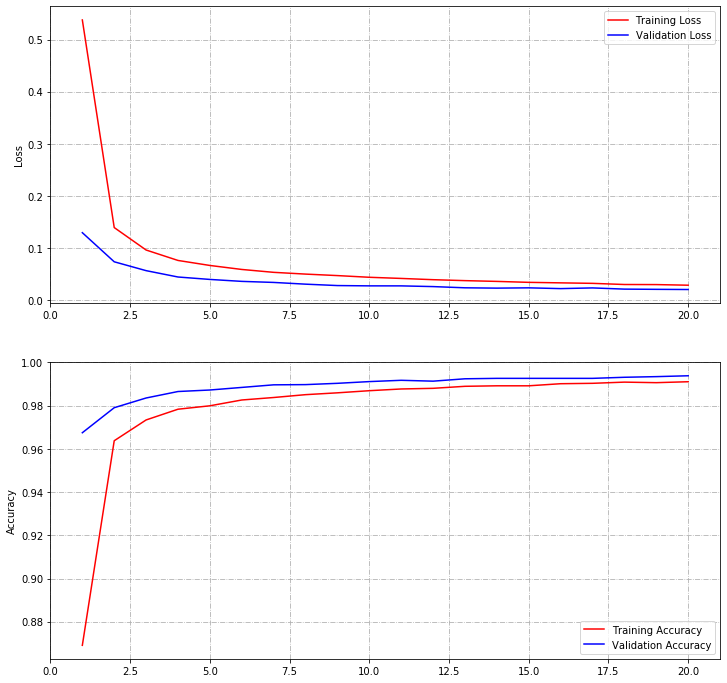

In [14]:
# plot training history
plt.figure(figsize=(12,12))
plt.subplot(2,1,1)
ax = plt.gca()
ax.set_xlim([0, e + 2])
plt.ylabel('Loss')
plt.plot(range(1, e + 2), train_losses[:e+1], 'r', label='Training Loss')
plt.plot(range(1, e + 2), val_losses[:e+1], 'b', label='Validation Loss')
ax.grid(linestyle='-.')
plt.legend()
plt.subplot(2,1,2)
ax = plt.gca()
ax.set_xlim([0, e+2])
plt.ylabel('Accuracy')
plt.plot(range(1, e + 2), train_accu[:e+1], 'r', label='Training Accuracy')
plt.plot(range(1, e + 2), val_accu[:e+1], 'b', label='Validation Accuracy')
ax.grid(linestyle='-.')
plt.legend()
plt.show()